# Diploma XXX

## Setup

### import necesery liblaries

In [ ]:
import torch
import wandb
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from tinyai.imports import *
from torcheval.metrics import *
import pdb

[2024-04-09 23:43:55,959] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### Config


In this configuration, we are setting up various parameters and options for our workflow.

- Setting the precision, linewidth, and scientific notation mode for printing tensors.
- Setting the random seed for reproducibility.
- Configuring the color map and DPI for matplotlib figures.
- Setting the random seed and limiting the number of CPUs used. These configurations ensure consistent and optimized behavior throughout the workflow.


In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 100

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=10

## Wandb

In [ ]:
def test_model_accuracy(model, dataloader, metrics):
    accuracy_metric = metrics['accuracy']
    precision_metric = metrics['precision']
    recall_metric = metrics['recall']

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(def_device))
            _, predicted = torch.max(outputs.data, 1)
            accuracy_metric.update(predicted.to('cpu'), labels)
            precision_metric.update(predicted.to('cpu'), labels)
            recall_metric.update(predicted.to('cpu'), labels)

    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()

    return accuracy, precision, recall

In [ ]:
import wandb
class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='diploma', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn): wandb.init(project=self.project, config=self.config, name=self.config['name'])
    def after_fit(self, learn):
        #wandb.log({'color_dim': wandb.Image(astats.color_dim())})
        #wandb.log({'dead_chart': wandb.Image(astats.dead_chart())})
        #wandb.log({'plot_stats':wandb.Image(astats.plot_stats())})


        metrics = {
            'accuracy': MulticlassAccuracy(num_classes=10),
            'precision': MulticlassPrecision(num_classes=10, average='macro'),
            'recall': MulticlassRecall(num_classes=10, average='macro')
        }
        accuracy, precision, recall = test_model_accuracy(learn.model, dls.test, metrics)
        wandb.log({'test_accuracy': accuracy, 'test_precision': precision, 'test_recall': recall})
        wandb.finish()

    def after_epoch(self, learn):
        super().after_epoch(learn)
        wandb.log({'lr':learn.opt.param_groups[-1]['lr']})
        
        # Save the model on the 5th, 10th, and 20th epochs
        if learn.epoch == 4 or learn.epoch == 9 or learn.epoch == 19:
            metrics = {
                'accuracy': MulticlassAccuracy(num_classes=10),
                'precision': MulticlassPrecision(num_classes=10, average='macro'),
                'recall': MulticlassRecall(num_classes=10, average='macro')
            }

            accuracy, precision, recall = test_model_accuracy(learn.model, dls.test, metrics)
            wandb.log({'test_accuracy': accuracy, 'test_precision': precision, 'test_recall': recall})

            model_filename = f"{self.config['name']}_{learn.epoch + 1}.pth"
            torch.save(learn.model.state_dict(), f'models/{model_filename}')
            wandb.save(model_filename)

    def _log(self, d):
        if d.get('train') == 'train':
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
        print(d)


    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({'loss':learn.loss})
        wandb.log({'accuracy': learn.metrics.metrics['accuracy'].compute()})
        wandb.log({'precision': learn.metrics.metrics['precision'].compute()})
        wandb.log({'recall': learn.metrics.metrics['recall'].compute()})


### Loading in FashionMNIST dataset the dataset and preparing the data for later use

In [ ]:
# Load the FashionMNIST dataset from Hugging Face
dataset = load_dataset('fashion_mnist')

bs= 512
epochs = 20
lr = 1e-2
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Lets see the image

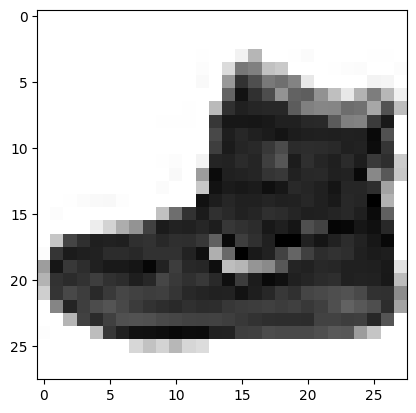

In [ ]:
image = dataset['train'][0]['image']
plt.imshow(image);

Transforming a PIL image to a Tensor is necessary  because it allows us to perform various operations on the image using PyTorch.

- PyTorch works with tensors as the primary data structure for representing and manipulating data.
- We can leverage GPUs for accelerated computation. Tensors can be easily moved to and processed on GPUs, enabling faster training and inference.

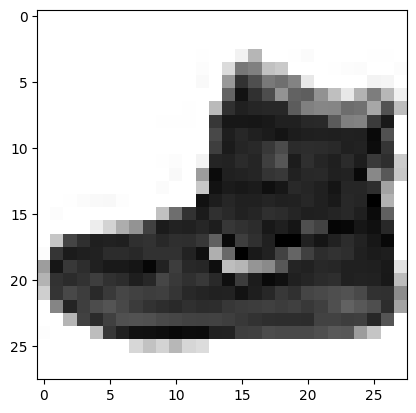

In [ ]:
plt.imshow(transforms.ToTensor()(image)[0]);

Lets create a function that will this to whole dataset

In [ ]:
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)) for o in b['image']]
# test if we want values btween -0.5 and 0.5 or 0 and 1

In [ ]:
dataset = dataset.with_transform(transformi)
image = dataset['train'][0]['image']
image.shape

torch.Size([1, 28, 28])

In [ ]:
dls = DataLoaders.from_dd(dataset,batch_size=bs,test=True ,split = 0.1, num_workers=10, pin_memory=True)
next(iter(dls.train))[0].shape, next(iter(dls.valid))[0].shape, next(iter(dls.test))[0].shape

(torch.Size([512, 1, 28, 28]),
 torch.Size([1024, 1, 28, 28]),
 torch.Size([1024, 1, 28, 28]))

```python
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=10),
                    precision=MulticlassPrecision(num_classes=10, average='macro'),
                    recall=MulticlassRecall(num_classes=10, average='macro'))

astats = ActivationStats(fc.risinstance(GeneralRelu))
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'Leaky ReLU'}, project='diploma run')
cbs = [DeviceCB(), ProgressCB(plot=True),MetricsCB(), astats , metrics, wandbcb]

iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)


learn.fit(5)
```

#  Baseline model

####  Exaplin what ResBlock is doing and make graphical representation of it
```python
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks // 2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res
    
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))
```

In [ ]:
def get_model(act=GeneralRelu,norm=False):
    layers = [ResBlock(1, 16, stride=1, act=act, norm=norm),
              # Why we stride 2 here? Because we want to reduce the size of the image by half
              ResBlock(16, 32, stride=2, act=act, norm=norm),
              ResBlock(32, 64, stride=2, act=act, norm=norm),
              ResBlock(64, 128, stride=2, act=act, norm=norm),
              ResBlock(128, 256, stride=2, act=act, norm=norm),
              ResBlock(256, 512, stride=2, act=act, norm=norm),
              nn.Flatten(),
              nn.Linear(512, 10, bias=False),
        ]
    if norm:
        layers.append(nn.BatchNorm1d(10))
    return nn.Sequential(*layers)
get_model();

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=10),
                    precision=MulticlassPrecision(num_classes=10, average='macro'),
                    recall=MulticlassRecall(num_classes=10, average='macro'))

In [ ]:
#astats = ActivationStats(fc.risinstance(GeneralRelu))
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'baseline'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), wandbcb]
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

In [ ]:
learn.fit(epochs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: afterhoursbilly. Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

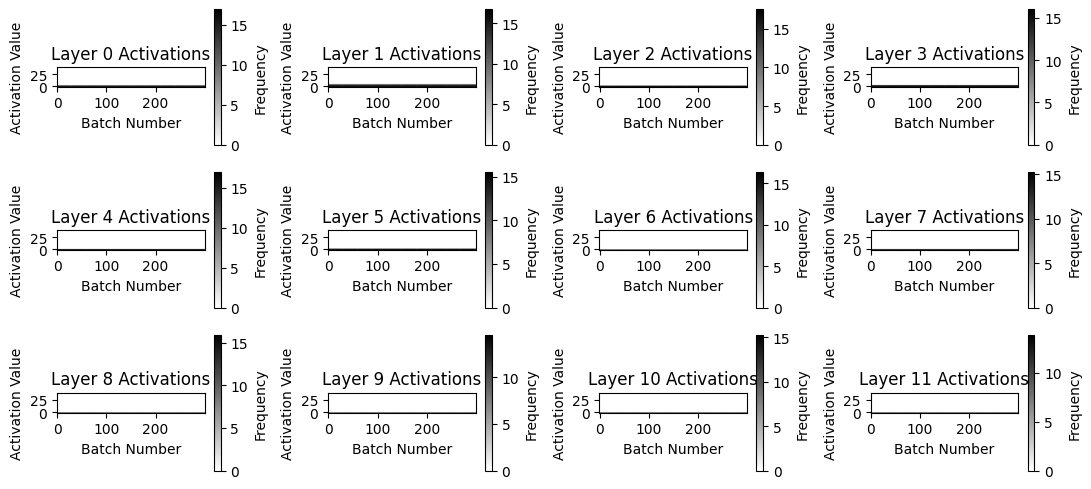

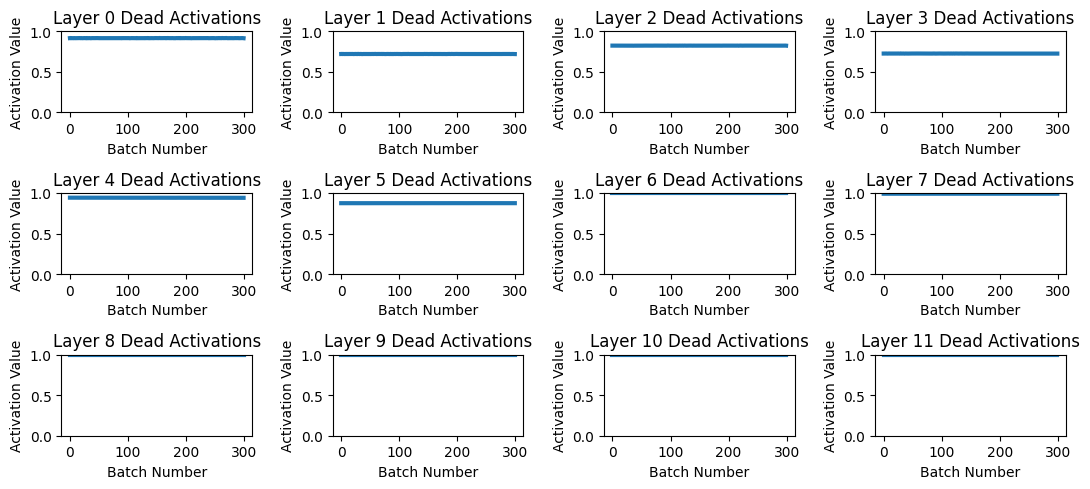

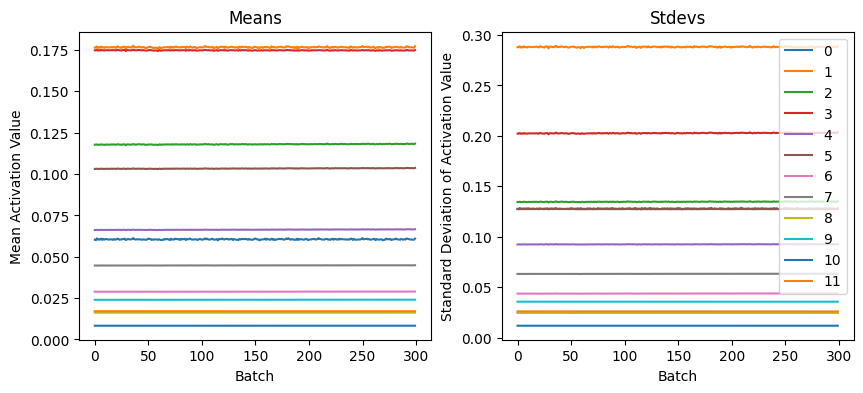

In [ ]:
def print_activ():
    astats.color_dim()
    astats.dead_chart()
    astats.plot_stats()
print_activ()


# Data Normalization

Since our model is not training, it is important to normalize the data to ensure that all features are on a similar scale. This helps in improving the performance and convergence of the model during training.

To normalize the data, we can...

In [ ]:
image.mean(), image.std()

(tensor(0.3814), tensor(0.3994))

In [ ]:
xmean,xstd = next(iter(dls.train))[0].mean(), next(iter(dls.train))[0].std()
print(xmean, xstd)
xmean,xstd = 0.28, 0.35 # values from whole dataset not only one sample 

tensor(0.2800) tensor(0.3567)


In [ ]:
@inplace
def transformi(b): b['image'] = [(((TF.to_tensor(o)-xmean)/xstd)) for o in b['image']]


tds = dataset.with_transform(transformi)
dls = DataLoaders.from_dd(tds,batch_size=bs,test=True ,split = 0.1, num_workers=10, pin_memory=True)
xb,yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(-0.0028), tensor(0.9924))

In [ ]:
for i in range(5):
    print(xb[i].mean(), xb[i].std())

tensor(-0.4171) tensor(0.4942)
tensor(-0.3696) tensor(0.4892)
tensor(-0.5204) tensor(0.5108)
tensor(0.0437) tensor(0.7388)
tensor(0.1201) tensor(0.8638)


Not every image has mean - 0, std - 1, but the whole batch is close to it and this is what mattters.\

### Lets try trainning with normalized input's

In [ ]:
set_seed(42)

In [ ]:
set_seed(43)

In [ ]:
#astats = ActivationStats(fc.risinstance(GeneralRelu))
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'NormalizedInput_v3'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True),wandbcb]
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▅▅▇▇▇█████
loss,████████████████████████████▇▆▄▃▂▂▁▂▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▆▇▇▇▇███
recall,▁▁▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▅▅▇▇▇▇████
test_accuracy,▁▁▂▂███
test_precision,▁▁▂▂███
test_recall,▁▁▂▂███
train_loss,██████████████▇▄▂▂▁▁
val_loss,██████████████▆▃▂▂▂▁
accuracy,0.68317


accuracy,precision,recall,loss,epoch,train
0.100,0.010,0.100,2.303,0,train
0.101,0.010,0.100,2.303,0,eval
0.100,0.010,0.100,2.303,1,train
0.101,0.010,0.100,2.303,1,eval
0.100,0.010,0.100,2.302,2,train
0.101,0.010,0.100,2.302,2,eval
0.100,0.010,0.100,2.302,3,train
0.101,0.010,0.100,2.302,3,eval
0.100,0.024,0.100,2.302,4,train
0.101,0.010,0.100,2.302,4,eval


{'loss': '2.303', 'epoch': 0, 'train': 'train'}


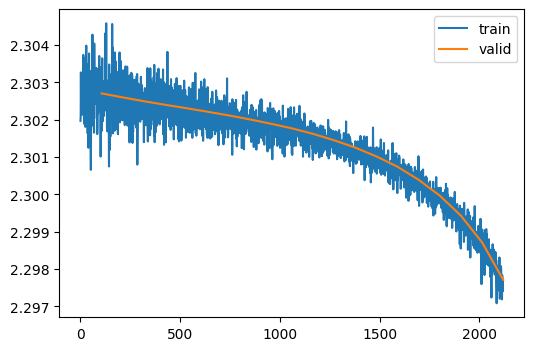

{'loss': '2.303', 'epoch': 0, 'train': 'eval'}
{'loss': '2.303', 'epoch': 1, 'train': 'train'}
{'loss': '2.303', 'epoch': 1, 'train': 'eval'}
{'loss': '2.302', 'epoch': 2, 'train': 'train'}
{'loss': '2.302', 'epoch': 2, 'train': 'eval'}
{'loss': '2.302', 'epoch': 3, 'train': 'train'}
{'loss': '2.302', 'epoch': 3, 'train': 'eval'}
{'loss': '2.302', 'epoch': 4, 'train': 'train'}
{'loss': '2.302', 'epoch': 4, 'train': 'eval'}
{'loss': '2.302', 'epoch': 5, 'train': 'train'}
{'loss': '2.302', 'epoch': 5, 'train': 'eval'}
{'loss': '2.302', 'epoch': 6, 'train': 'train'}
{'loss': '2.302', 'epoch': 6, 'train': 'eval'}
{'loss': '2.302', 'epoch': 7, 'train': 'train'}
{'loss': '2.302', 'epoch': 7, 'train': 'eval'}
{'loss': '2.302', 'epoch': 8, 'train': 'train'}
{'loss': '2.302', 'epoch': 8, 'train': 'eval'}
{'loss': '2.302', 'epoch': 9, 'train': 'train'}
{'loss': '2.302', 'epoch': 9, 'train': 'eval'}
{'loss': '2.302', 'epoch': 10, 'train': 'train'}
{'loss': '2.302', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

In [ ]:
import re

pattern = r"([\d\.]+),([\d\.]+),tensor\(\[([\d\.,\s]+)\]\)"


file_path = 'data/activations/test'
def get_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    return data
data = get_data(file_path)

matches = re.findall(pattern, data)
len(matches)

25800

In [ ]:
means = []
stds = []
hists = []

for match in matches:
    means.append(float(match[0]))
    stds.append(float(match[1]))
    hists.append([float(x) for x in match[2].replace('\n', ' ').split(', ')])

In [ ]:
stats = [means, stds, hists]

In [ ]:
means[0:11]

[0.2743784487247467,
 0.2749512791633606,
 0.11825732886791229,
 0.1678227335214615,
 0.06495692580938339,
 0.08036427944898605,
 0.03453977406024933,
 0.04906846582889557,
 0.01742062345147133,
 0.02629675343632698,
 0.008005857467651367]

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
4 0
4 1
5 0
5 1
6 0
6 1
7 0
7 1
8 0
8 1
9 0
9 1
10 0
10 1
11 0
11 1


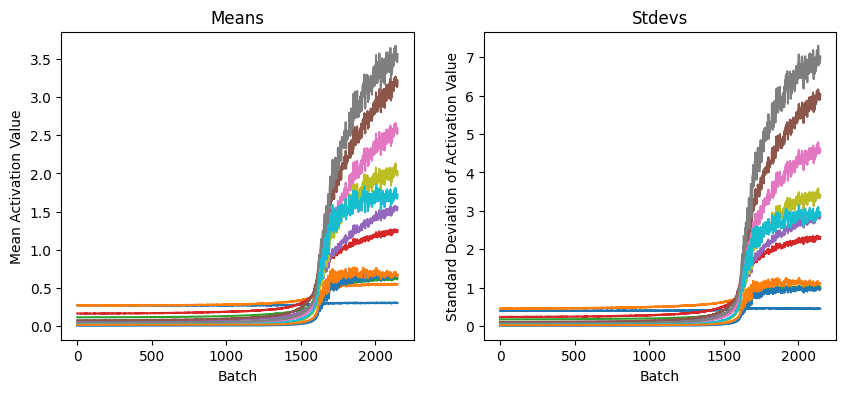

In [ ]:
def plot_stats(stats, figsize=(10,4)):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    for j in range(12):
        for i in (0, 1):
            print(j, i)
            axs[i].plot([stats[i][x] for x in range(j, 25800, 12)])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        axs[0].set_xlabel("Batch")
        axs[1].set_xlabel("Batch")
        axs[0].set_ylabel("Mean Activation Value")
        axs[1].set_ylabel("Standard Deviation of Activation Value")
    return fig # Allows for logging

plot_stats(stats);


In [ ]:
def print_activ(figsize = (11,5)):
    astats.color_dim(figsize)
    astats.dead_chart(figsize)
    astats.plot_stats(figsize)
print_activ()

AttributeError: 'ActivationStats' object has no attribute 'hooks'

Here we can see that some of our activation are starting to move but the mean and std are still incorect. \
The reason is it dosn't matter that our input are normalized if are weight are not and after layer we lose the normalization.
The solution is to initialize our weight and not use random weights(the ones we were using before).

In [ ]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
#astats = ActivationStats(fc.risinstance(GeneralRelu))
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'Init Weights'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), wandbcb]
iw = partial(init_weights)
model = get_model().apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▃▃▃▂▃▃▅▅▇▇██
loss,███████████████████████████████▇▇▆▄▃▂▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▂▂▁▁▂▂▂▂▂▃▃▂▄▅▅▅▅▅▅▆▇▇▇█
recall,▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▃▂▂▂▃▃▅▅▇▇██
test_accuracy,▁▁▁▁███
test_precision,▁▁▁▁███
test_recall,▁▁▁▁███
train_loss,████████████████▇▄▂▁
val_loss,███████████████▇▆▂▁▁
accuracy,0.63483


accuracy,precision,recall,loss,epoch,train
0.601,0.595,0.600,1.233,0,train
0.750,0.758,0.752,0.651,0,eval
0.765,0.761,0.764,0.620,1,train
0.783,0.798,0.785,0.574,1,eval
0.805,0.801,0.804,0.522,2,train
0.778,0.826,0.779,0.625,2,eval
0.825,0.823,0.825,0.473,3,train
0.809,0.833,0.811,0.504,3,eval
0.839,0.837,0.839,0.438,4,train
0.849,0.853,0.850,0.426,4,eval


{'loss': '1.233', 'epoch': 0, 'train': 'train'}


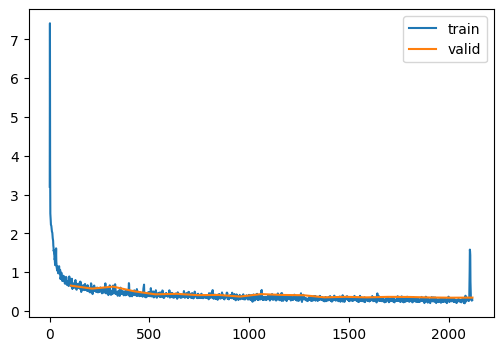

{'loss': '0.651', 'epoch': 0, 'train': 'eval'}
{'loss': '0.620', 'epoch': 1, 'train': 'train'}
{'loss': '0.574', 'epoch': 1, 'train': 'eval'}
{'loss': '0.522', 'epoch': 2, 'train': 'train'}
{'loss': '0.625', 'epoch': 2, 'train': 'eval'}
{'loss': '0.473', 'epoch': 3, 'train': 'train'}
{'loss': '0.504', 'epoch': 3, 'train': 'eval'}
{'loss': '0.438', 'epoch': 4, 'train': 'train'}
{'loss': '0.426', 'epoch': 4, 'train': 'eval'}
{'loss': '0.408', 'epoch': 5, 'train': 'train'}
{'loss': '0.439', 'epoch': 5, 'train': 'eval'}
{'loss': '0.396', 'epoch': 6, 'train': 'train'}
{'loss': '0.405', 'epoch': 6, 'train': 'eval'}
{'loss': '0.371', 'epoch': 7, 'train': 'train'}
{'loss': '0.411', 'epoch': 7, 'train': 'eval'}
{'loss': '0.359', 'epoch': 8, 'train': 'train'}
{'loss': '0.368', 'epoch': 8, 'train': 'eval'}
{'loss': '0.347', 'epoch': 9, 'train': 'train'}
{'loss': '0.432', 'epoch': 9, 'train': 'eval'}
{'loss': '0.343', 'epoch': 10, 'train': 'train'}
{'loss': '0.410', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

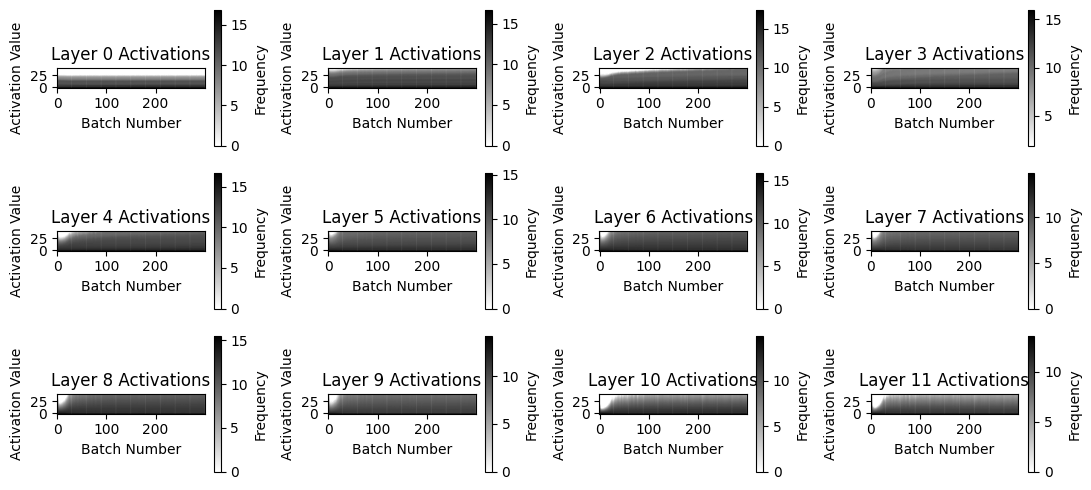

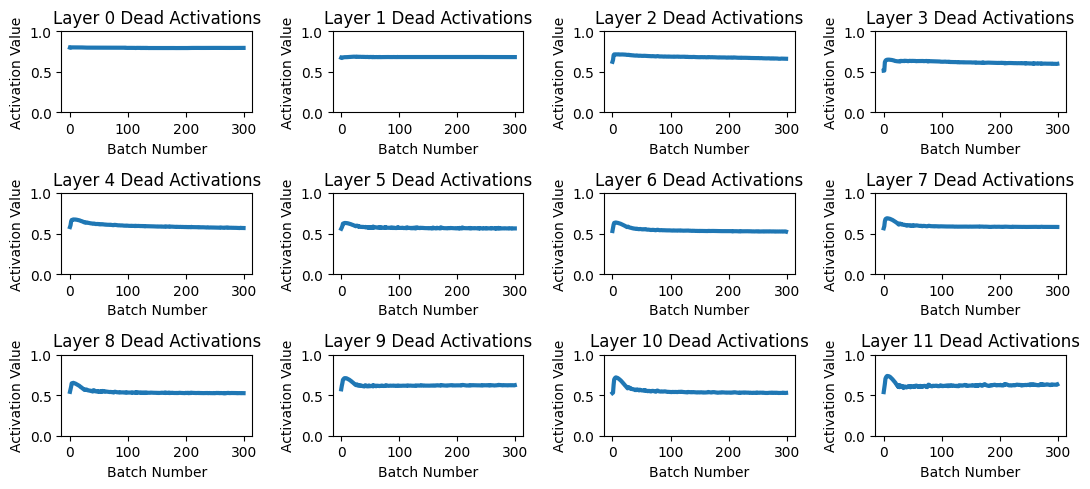

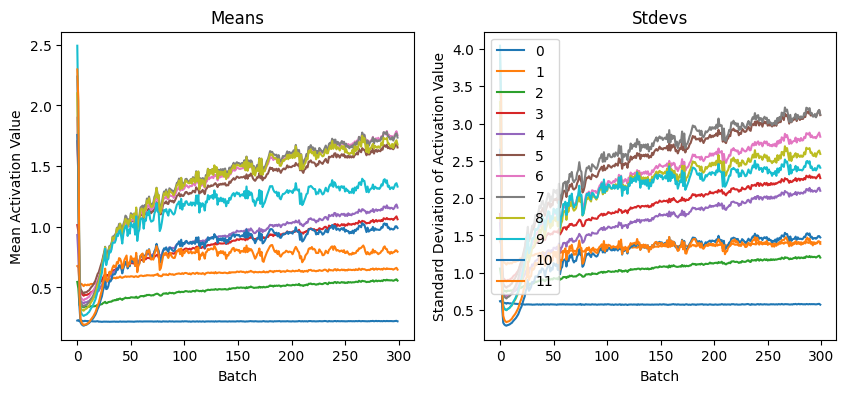

In [ ]:
print_activ()

# BatchNorm
We can also normalize the activations of the network by using BatchNorm. This technique normalizes the activations of each layer.


In [ ]:
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'Batch Norm'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), wandbcb]
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
loss,█▄▄▃▃▃▂▄▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
recall,▁▂▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
test_accuracy,▂▂▁▁███
test_precision,▁▁▂▂███
test_recall,▂▂▁▁███
train_loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▃▃▂▃▂▃▃▂▁▂▁▁▁▁▁▁
accuracy,0.87417


accuracy,precision,recall,loss,epoch,train
0.762,0.757,0.762,0.910,0,train
0.814,0.813,0.815,0.727,0,eval
0.842,0.840,0.842,0.666,1,train
0.843,0.845,0.844,0.633,1,eval
0.863,0.862,0.863,0.582,2,train
0.860,0.859,0.861,0.570,2,eval
0.876,0.875,0.875,0.522,3,train
0.870,0.872,0.871,0.527,3,eval
0.885,0.884,0.885,0.479,4,train
0.868,0.868,0.869,0.508,4,eval


{'loss': '0.910', 'epoch': 0, 'train': 'train'}


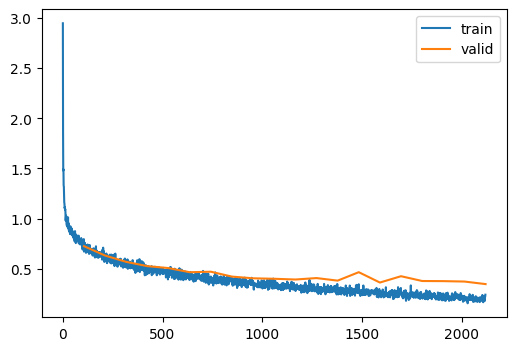

{'loss': '0.727', 'epoch': 0, 'train': 'eval'}
{'loss': '0.666', 'epoch': 1, 'train': 'train'}
{'loss': '0.633', 'epoch': 1, 'train': 'eval'}
{'loss': '0.582', 'epoch': 2, 'train': 'train'}
{'loss': '0.570', 'epoch': 2, 'train': 'eval'}
{'loss': '0.522', 'epoch': 3, 'train': 'train'}
{'loss': '0.527', 'epoch': 3, 'train': 'eval'}
{'loss': '0.479', 'epoch': 4, 'train': 'train'}
{'loss': '0.508', 'epoch': 4, 'train': 'eval'}
{'loss': '0.445', 'epoch': 5, 'train': 'train'}
{'loss': '0.467', 'epoch': 5, 'train': 'eval'}
{'loss': '0.415', 'epoch': 6, 'train': 'train'}
{'loss': '0.472', 'epoch': 6, 'train': 'eval'}
{'loss': '0.390', 'epoch': 7, 'train': 'train'}
{'loss': '0.423', 'epoch': 7, 'train': 'eval'}
{'loss': '0.366', 'epoch': 8, 'train': 'train'}
{'loss': '0.406', 'epoch': 8, 'train': 'eval'}
{'loss': '0.345', 'epoch': 9, 'train': 'train'}
{'loss': '0.402', 'epoch': 9, 'train': 'eval'}
{'loss': '0.327', 'epoch': 10, 'train': 'train'}
{'loss': '0.394', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

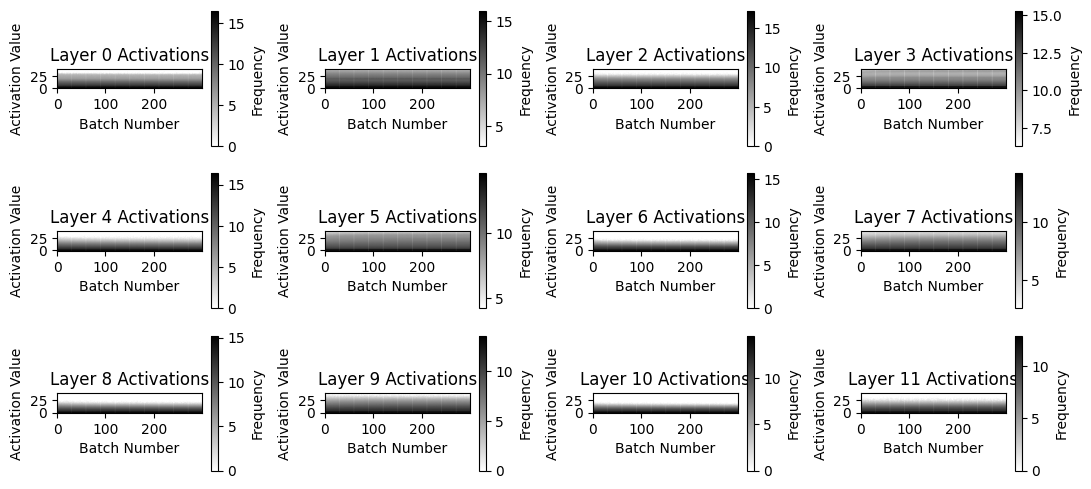

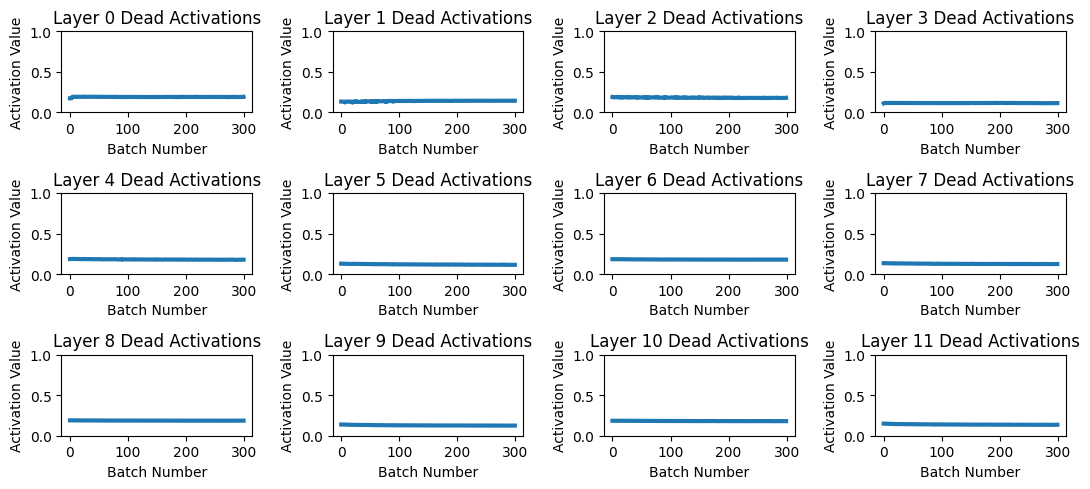

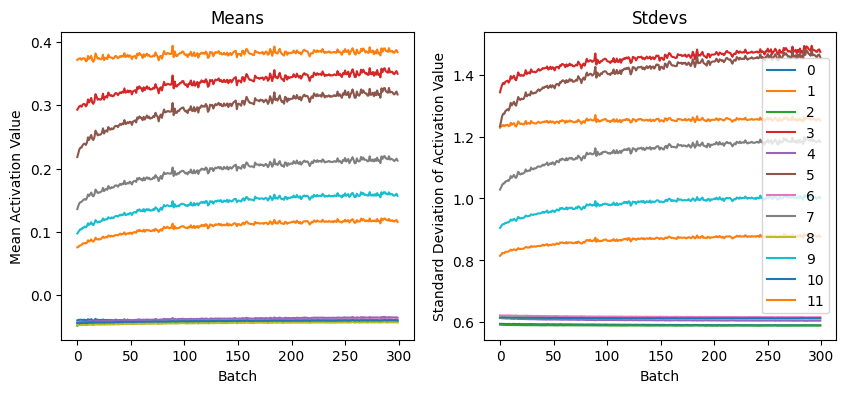

In [ ]:
print_activ()

# Leaky ReLU
----


In [ ]:
#astats = ActivationStats(fc.risinstance(GeneralRelu))
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'Leaky ReLU'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), wandbcb]


iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████▆
loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▂▁▁▁▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████▇
recall,▁▂▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████▇
test_accuracy,▂▁▅▅███
test_precision,▂▁▅▅███
test_recall,▂▁▅▅███
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▃▁▂▂▂▁▁
accuracy,0.89717


accuracy,precision,recall,loss,epoch,train
0.762,0.756,0.762,0.908,0,train
0.817,0.814,0.818,0.738,0,eval
0.839,0.837,0.839,0.669,1,train
0.840,0.839,0.841,0.634,1,eval
0.862,0.861,0.862,0.584,2,train
0.857,0.857,0.858,0.569,2,eval
0.875,0.874,0.875,0.527,3,train
0.868,0.868,0.869,0.527,3,eval
0.883,0.882,0.883,0.483,4,train
0.874,0.874,0.875,0.491,4,eval


{'loss': '0.908', 'epoch': 0, 'train': 'train'}


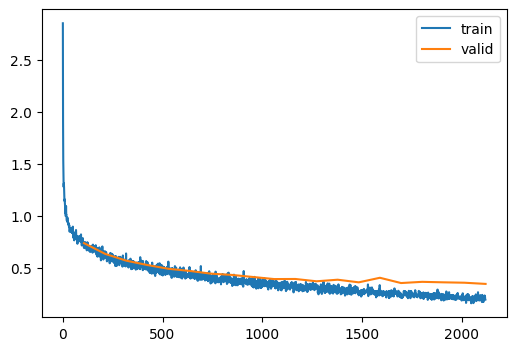

{'loss': '0.738', 'epoch': 0, 'train': 'eval'}
{'loss': '0.669', 'epoch': 1, 'train': 'train'}
{'loss': '0.634', 'epoch': 1, 'train': 'eval'}
{'loss': '0.584', 'epoch': 2, 'train': 'train'}
{'loss': '0.569', 'epoch': 2, 'train': 'eval'}
{'loss': '0.527', 'epoch': 3, 'train': 'train'}
{'loss': '0.527', 'epoch': 3, 'train': 'eval'}
{'loss': '0.483', 'epoch': 4, 'train': 'train'}
{'loss': '0.491', 'epoch': 4, 'train': 'eval'}
{'loss': '0.448', 'epoch': 5, 'train': 'train'}
{'loss': '0.470', 'epoch': 5, 'train': 'eval'}
{'loss': '0.419', 'epoch': 6, 'train': 'train'}
{'loss': '0.444', 'epoch': 6, 'train': 'eval'}
{'loss': '0.393', 'epoch': 7, 'train': 'train'}
{'loss': '0.432', 'epoch': 7, 'train': 'eval'}
{'loss': '0.370', 'epoch': 8, 'train': 'train'}
{'loss': '0.412', 'epoch': 8, 'train': 'eval'}
{'loss': '0.349', 'epoch': 9, 'train': 'train'}
{'loss': '0.392', 'epoch': 9, 'train': 'eval'}
{'loss': '0.330', 'epoch': 10, 'train': 'train'}
{'loss': '0.393', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

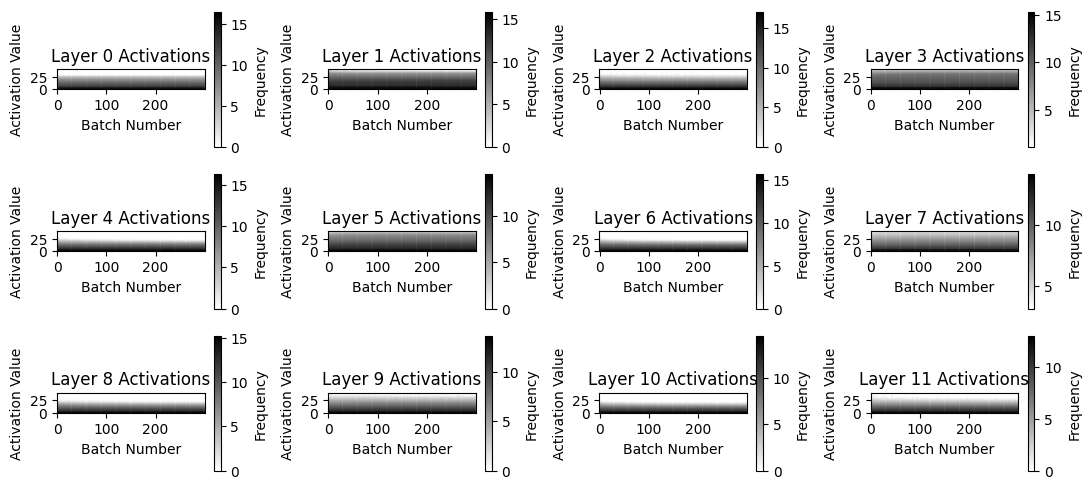

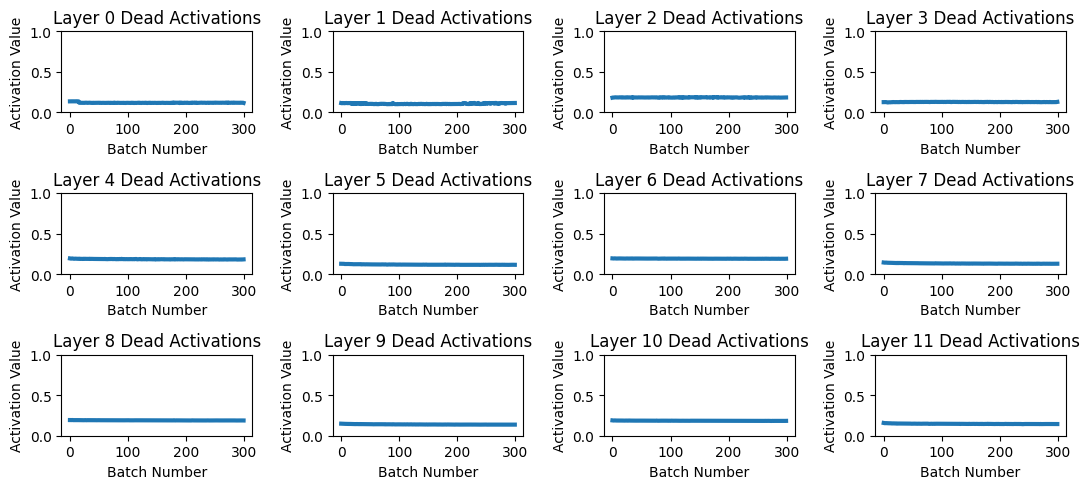

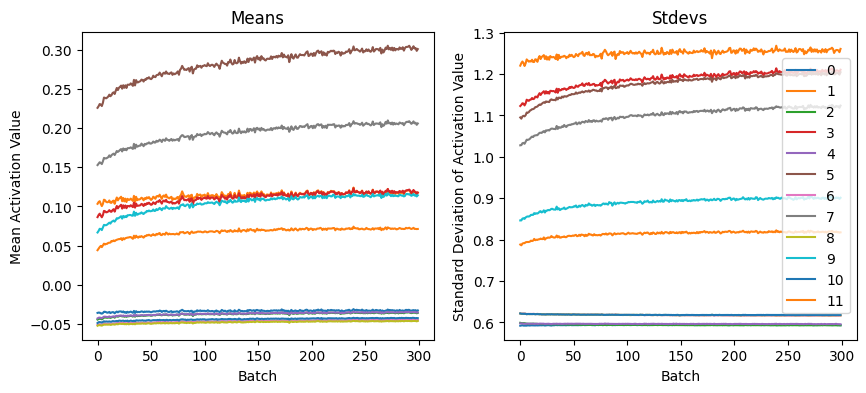

In [ ]:
print_activ()

# LR-sched

In [ ]:
def _lr(cb): return cb.pg['lr']
record = RecorderCB(lr = _lr)

In [ ]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

astats = ActivationStats(fc.risinstance(GeneralRelu))
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'lr_scheduler'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), wandbcb]


iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████▆
loss,█▇▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████▆
recall,▁▂▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████▆
test_accuracy,▁▁▇▆███
test_precision,▁▁▇▆███
test_recall,▁▁▇▆███
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▂▂▁▂▁▂▁▁▁▁▁
accuracy,0.89067


accuracy,precision,recall,loss,epoch,train
0.689,0.682,0.689,1.101,0,train
0.801,0.798,0.802,0.772,0,eval
0.837,0.835,0.837,0.651,1,train
0.857,0.857,0.859,0.551,1,eval
0.879,0.878,0.879,0.469,2,train
0.877,0.880,0.878,0.437,2,eval
0.903,0.903,0.903,0.359,3,train
0.885,0.885,0.886,0.383,3,eval
0.921,0.921,0.921,0.286,4,train
0.894,0.895,0.895,0.339,4,eval


{'loss': '1.101', 'epoch': 0, 'train': 'train'}


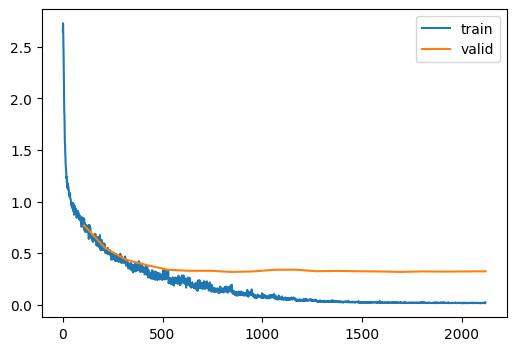

{'loss': '0.772', 'epoch': 0, 'train': 'eval'}
{'loss': '0.651', 'epoch': 1, 'train': 'train'}
{'loss': '0.551', 'epoch': 1, 'train': 'eval'}
{'loss': '0.469', 'epoch': 2, 'train': 'train'}
{'loss': '0.437', 'epoch': 2, 'train': 'eval'}
{'loss': '0.359', 'epoch': 3, 'train': 'train'}
{'loss': '0.383', 'epoch': 3, 'train': 'eval'}
{'loss': '0.286', 'epoch': 4, 'train': 'train'}
{'loss': '0.339', 'epoch': 4, 'train': 'eval'}
{'loss': '0.232', 'epoch': 5, 'train': 'train'}
{'loss': '0.330', 'epoch': 5, 'train': 'eval'}
{'loss': '0.185', 'epoch': 6, 'train': 'train'}
{'loss': '0.330', 'epoch': 6, 'train': 'eval'}
{'loss': '0.145', 'epoch': 7, 'train': 'train'}
{'loss': '0.319', 'epoch': 7, 'train': 'eval'}
{'loss': '0.110', 'epoch': 8, 'train': 'train'}
{'loss': '0.324', 'epoch': 8, 'train': 'eval'}
{'loss': '0.082', 'epoch': 9, 'train': 'train'}
{'loss': '0.340', 'epoch': 9, 'train': 'eval'}
{'loss': '0.062', 'epoch': 10, 'train': 'train'}
{'loss': '0.341', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

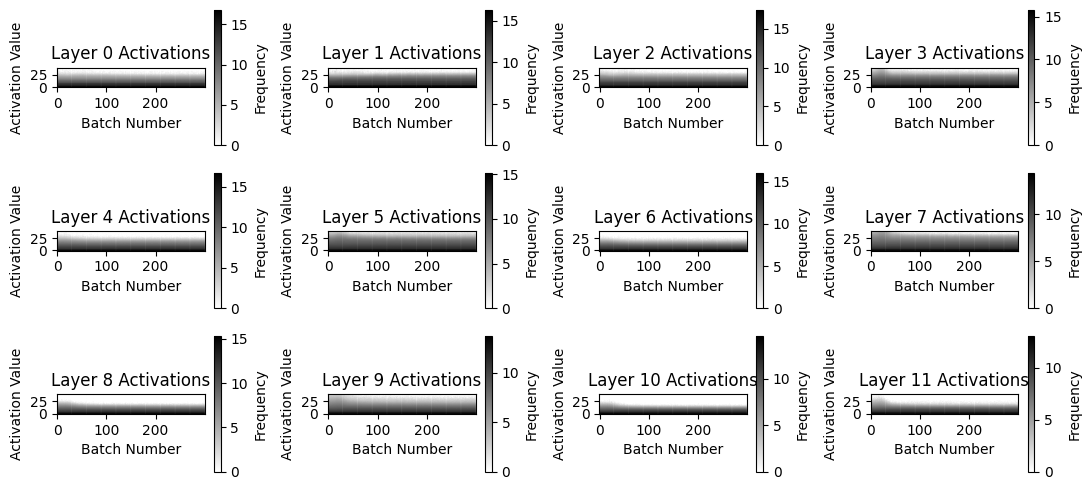

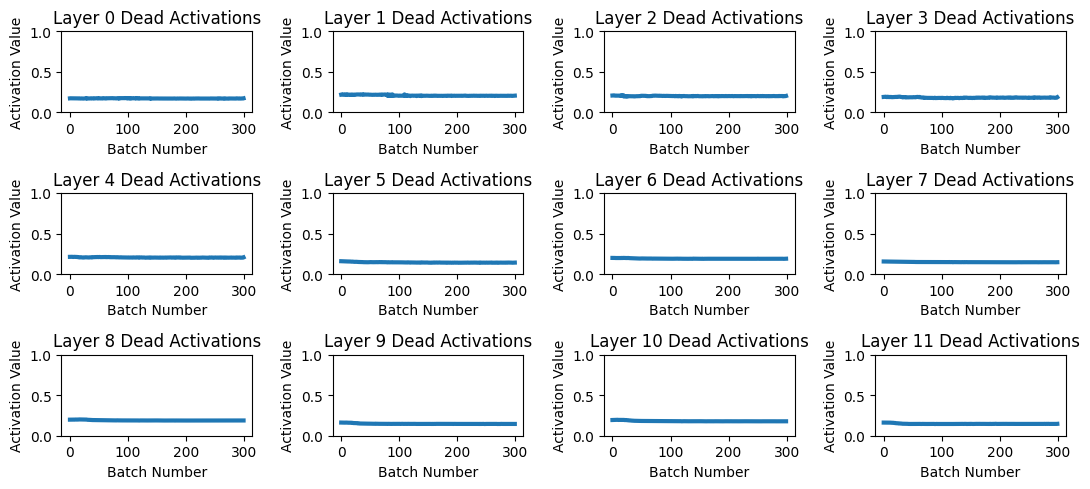

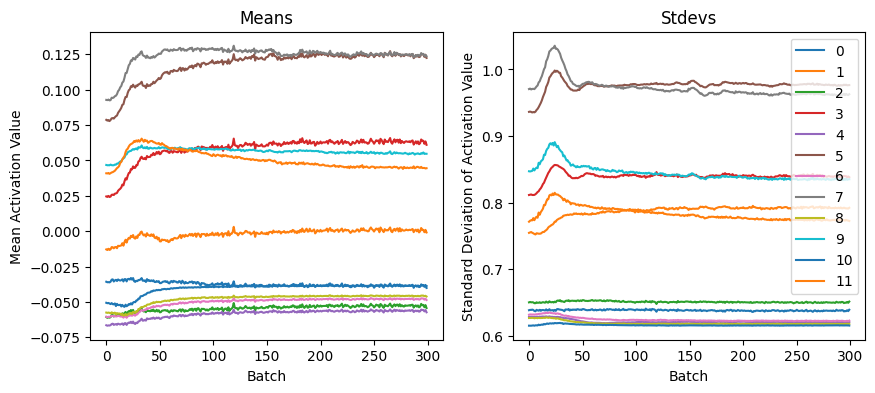

In [ ]:
print_activ()

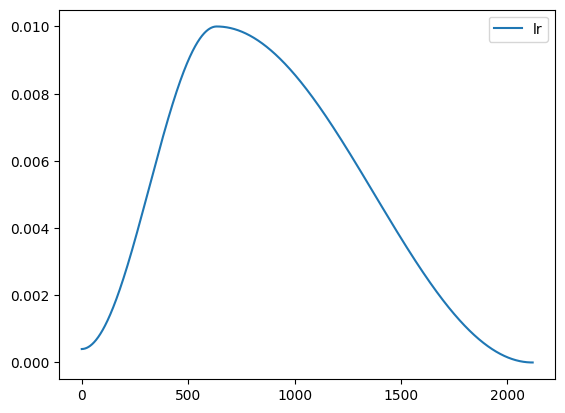

In [ ]:
record.plot()

# AdamW

In [ ]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
record = RecorderCB(lr = _lr, mom = _beta1)

In [ ]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'AdamW'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), wandbcb]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████▇
loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃
lr,▂▂▃▃▅▅▆▆████████▇▇▇▇▆▆▅▅▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁
precision,▁▃▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████▇
recall,▁▃▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████▇
test_accuracy,▁▁▄▄▇██
test_precision,▁▁▄▄▇██
test_recall,▁▁▄▄▇██
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9055


accuracy,precision,recall,loss,epoch,train
0.842,0.841,0.842,0.673,0,train
0.879,0.884,0.879,0.502,0,eval
0.903,0.902,0.903,0.454,1,train
0.886,0.893,0.887,0.451,1,eval
0.911,0.911,0.911,0.350,2,train
0.891,0.894,0.891,0.344,2,eval
0.917,0.916,0.917,0.282,3,train
0.878,0.887,0.878,0.382,3,eval
0.925,0.924,0.924,0.238,4,train
0.924,0.925,0.924,0.243,4,eval


{'loss': '0.673', 'epoch': 0, 'train': 'train'}


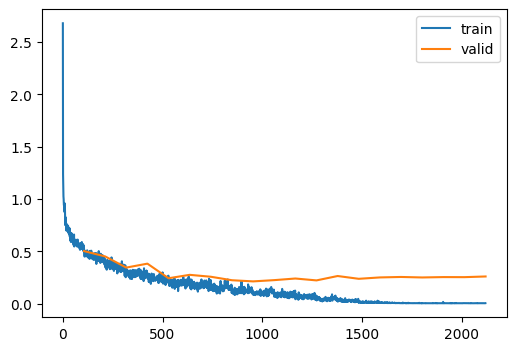

{'loss': '0.502', 'epoch': 0, 'train': 'eval'}
{'loss': '0.454', 'epoch': 1, 'train': 'train'}
{'loss': '0.451', 'epoch': 1, 'train': 'eval'}
{'loss': '0.350', 'epoch': 2, 'train': 'train'}
{'loss': '0.344', 'epoch': 2, 'train': 'eval'}
{'loss': '0.282', 'epoch': 3, 'train': 'train'}
{'loss': '0.382', 'epoch': 3, 'train': 'eval'}
{'loss': '0.238', 'epoch': 4, 'train': 'train'}
{'loss': '0.243', 'epoch': 4, 'train': 'eval'}
{'loss': '0.201', 'epoch': 5, 'train': 'train'}
{'loss': '0.275', 'epoch': 5, 'train': 'eval'}
{'loss': '0.175', 'epoch': 6, 'train': 'train'}
{'loss': '0.257', 'epoch': 6, 'train': 'eval'}
{'loss': '0.149', 'epoch': 7, 'train': 'train'}
{'loss': '0.224', 'epoch': 7, 'train': 'eval'}
{'loss': '0.125', 'epoch': 8, 'train': 'train'}
{'loss': '0.212', 'epoch': 8, 'train': 'eval'}
{'loss': '0.105', 'epoch': 9, 'train': 'train'}
{'loss': '0.225', 'epoch': 9, 'train': 'eval'}
{'loss': '0.085', 'epoch': 10, 'train': 'train'}
{'loss': '0.240', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

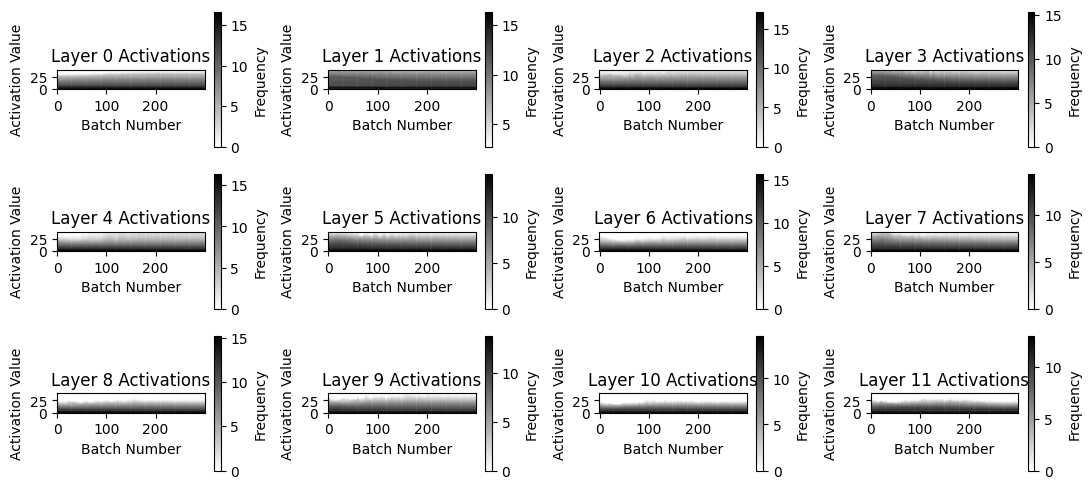

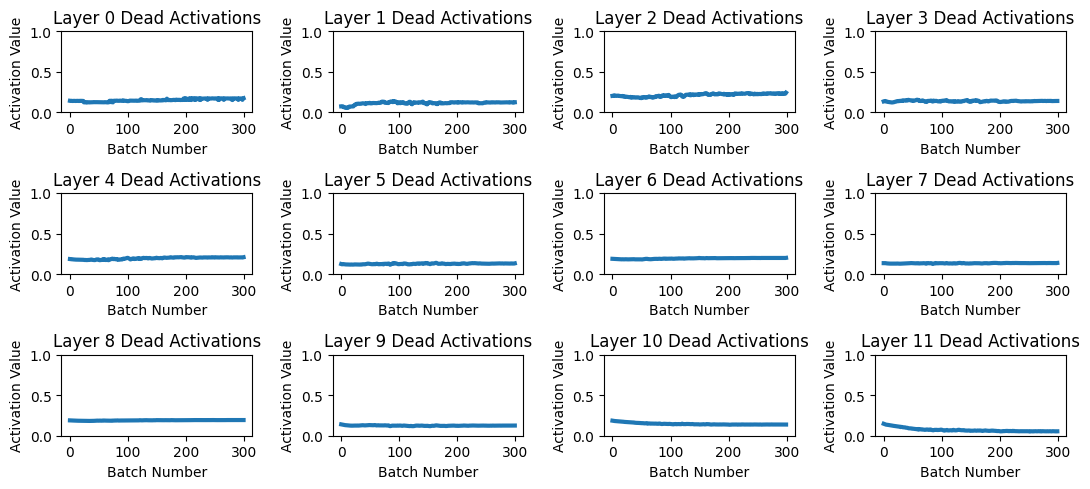

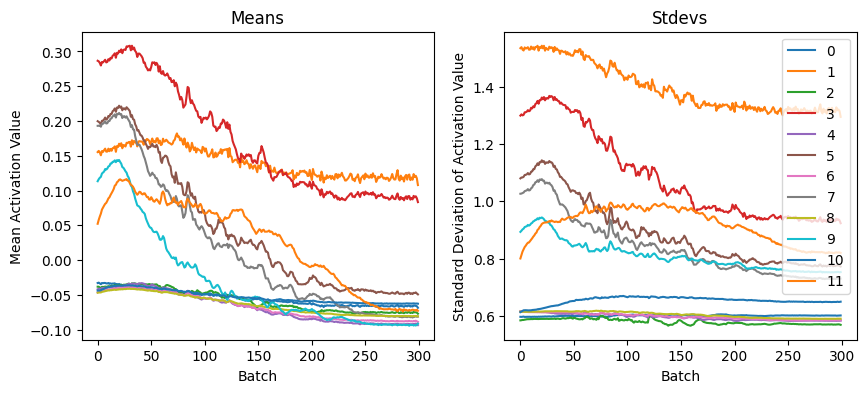

In [ ]:
print_activ()

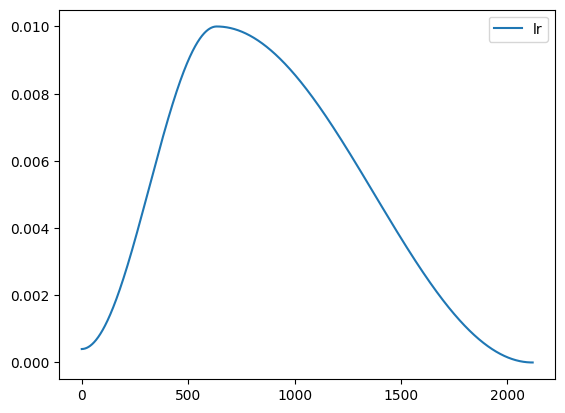

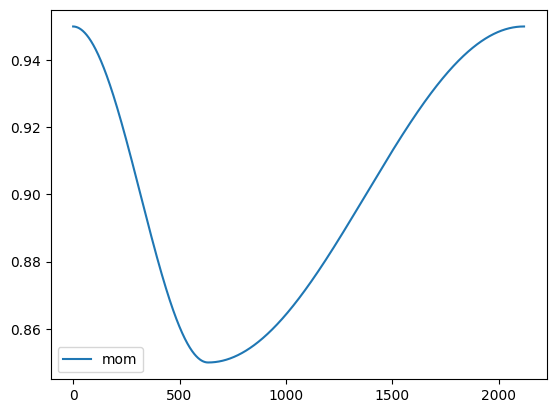

In [ ]:
record.plot()

# Augment

In [ ]:
#@inplace
#def transformi(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]


@inplace
def transformi(b): b['image'] = [(((F.pad(TF.to_tensor(o), (2,2,2,2))) -xmean)/xstd) for o in b['image']]


tds = dataset.with_transform(transformi)
dls = DataLoaders.from_dd(tds,batch_size=bs,test=True ,split = 0.1, num_workers=10, pin_memory=True)
xb,yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(-0.1576), tensor(0.9625))

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]).to('cuda'),tfm_y(b[1].to('cuda'))
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'Augmented Data'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True),augcb, wandbcb]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw).to(def_device)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████▆
loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▄
lr,▂▂▃▃▅▅▆▆████████▇▇▇▇▆▆▅▅▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁
precision,▁▃▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████▆
recall,▁▂▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████▆
test_accuracy,▁▁▄▄███
test_precision,▁▁▄▄███
test_recall,▁▁▄▄███
train_loss,█▆▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▇▄▅▂▃▂▁▁▁▂▁▂▂▂▂▂▂▂▂
accuracy,0.93683


accuracy,precision,recall,loss,epoch,train
0.710,0.705,0.710,0.994,0,train
0.747,0.750,0.750,0.856,0,eval
0.809,0.806,0.809,0.690,1,train
0.731,0.770,0.735,0.836,1,eval
0.822,0.820,0.822,0.587,2,train
0.672,0.772,0.672,0.936,2,eval
0.844,0.842,0.844,0.479,3,train
0.828,0.849,0.831,0.500,3,eval
0.855,0.854,0.855,0.418,4,train
0.868,0.872,0.869,0.384,4,eval


{'loss': '0.994', 'epoch': 0, 'train': 'train'}


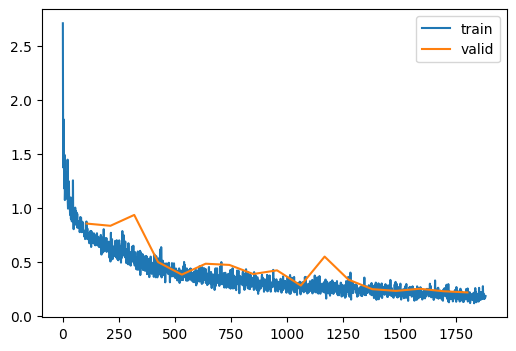

{'loss': '0.856', 'epoch': 0, 'train': 'eval'}
{'loss': '0.690', 'epoch': 1, 'train': 'train'}
{'loss': '0.836', 'epoch': 1, 'train': 'eval'}
{'loss': '0.587', 'epoch': 2, 'train': 'train'}
{'loss': '0.936', 'epoch': 2, 'train': 'eval'}
{'loss': '0.479', 'epoch': 3, 'train': 'train'}
{'loss': '0.500', 'epoch': 3, 'train': 'eval'}
{'loss': '0.418', 'epoch': 4, 'train': 'train'}
{'loss': '0.384', 'epoch': 4, 'train': 'eval'}
{'loss': '0.373', 'epoch': 5, 'train': 'train'}
{'loss': '0.485', 'epoch': 5, 'train': 'eval'}
{'loss': '0.344', 'epoch': 6, 'train': 'train'}
{'loss': '0.473', 'epoch': 6, 'train': 'eval'}
{'loss': '0.325', 'epoch': 7, 'train': 'train'}
{'loss': '0.389', 'epoch': 7, 'train': 'eval'}
{'loss': '0.298', 'epoch': 8, 'train': 'train'}
{'loss': '0.423', 'epoch': 8, 'train': 'eval'}
{'loss': '0.279', 'epoch': 9, 'train': 'train'}
{'loss': '0.283', 'epoch': 9, 'train': 'eval'}
{'loss': '0.269', 'epoch': 10, 'train': 'train'}
{'loss': '0.550', 'epoch': 10, 'train': 'eval'}
{

In [ ]:
learn.fit(epochs)

# Dropout

In [ ]:
def get_dropmodel(act=GeneralRelu,norm=False,drop=0.1):
    layers = [ResBlock(1, 16, stride=1, act=act, norm=norm),
              # Why we stride 2 here? Because we want to reduce the size of the image by half
              ResBlock(16, 32, stride=2, act=act, norm=norm),
              ResBlock(32, 64, stride=2, act=act, norm=norm),
              ResBlock(64, 128, stride=2, act=act, norm=norm),
              ResBlock(128, 256, stride=2, act=act, norm=norm),
              ResBlock(256, 512, stride=2, act=act, norm=norm),
              nn.Flatten(),
              nn.Dropout(drop),
              nn.Linear(512, 10, bias=False),
        ]
    if norm:
        layers.append(nn.BatchNorm1d(10))
    return nn.Sequential(*layers)

In [ ]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':'Dropout'}, project='diploma run')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True),augcb, wandbcb]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_dropmodel(act_gr,norm=nn.BatchNorm2d,drop=0.1).apply(iw).to(def_device)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

loss,epoch,train
1.266,0,train
1.177,0,eval
0.845,1,train
0.789,1,eval
0.703,2,train
0.882,2,eval
0.599,3,train
0.664,3,eval
0.535,4,train
0.859,4,eval


{'loss': '1.266', 'epoch': 0, 'train': 'train'}


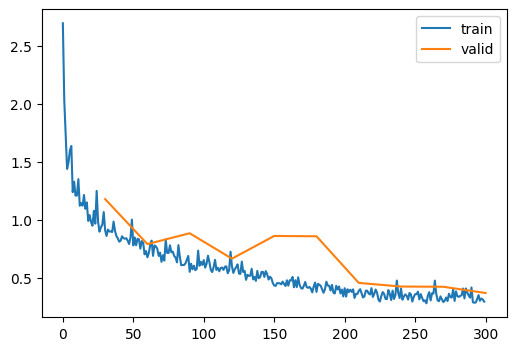

{'loss': '1.177', 'epoch': 0, 'train': 'eval'}
{'loss': '0.845', 'epoch': 1, 'train': 'train'}
{'loss': '0.789', 'epoch': 1, 'train': 'eval'}
{'loss': '0.703', 'epoch': 2, 'train': 'train'}
{'loss': '0.882', 'epoch': 2, 'train': 'eval'}
{'loss': '0.599', 'epoch': 3, 'train': 'train'}
{'loss': '0.664', 'epoch': 3, 'train': 'eval'}
{'loss': '0.535', 'epoch': 4, 'train': 'train'}
{'loss': '0.859', 'epoch': 4, 'train': 'eval'}
{'loss': '0.440', 'epoch': 5, 'train': 'train'}
{'loss': '0.856', 'epoch': 5, 'train': 'eval'}
{'loss': '0.395', 'epoch': 6, 'train': 'train'}
{'loss': '0.454', 'epoch': 6, 'train': 'eval'}
{'loss': '0.360', 'epoch': 7, 'train': 'train'}
{'loss': '0.423', 'epoch': 7, 'train': 'eval'}
{'loss': '0.341', 'epoch': 8, 'train': 'train'}
{'loss': '0.421', 'epoch': 8, 'train': 'eval'}
{'loss': '0.335', 'epoch': 9, 'train': 'train'}
{'loss': '0.367', 'epoch': 9, 'train': 'eval'}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
lr,▃▃▆▆████▇▇▅▅▄▄▂▂▁▁▁▁
train_loss,█▅▄▃▃▂▁▁▁▁
val_loss,█▅▅▄▅▅▂▁▁▁
loss,0.3588
lr,0.0
train_loss,0.335
val_loss,0.367


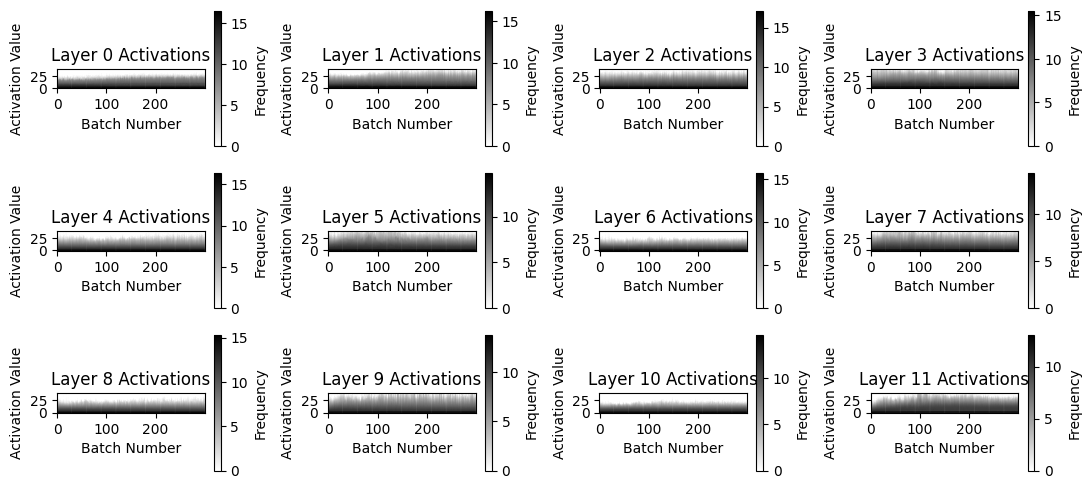

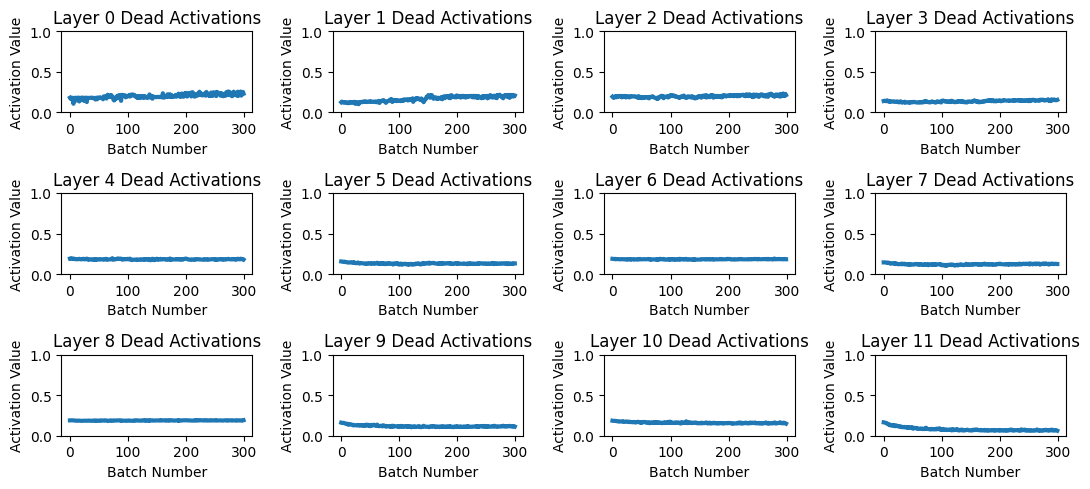

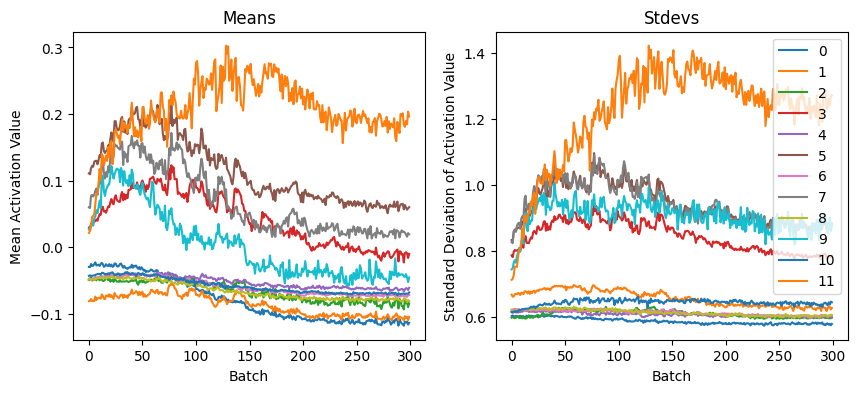

In [ ]:
learn.fit(epochs)